In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from numba import njit

from data_utils import *
from strategies import AssetBuildConfig, SpreadCaptureConfig, run_spread_capture_backtest, BookPressureConfig, run_book_pressure_strategy

### Data Processing

In [18]:
with open("btcusdt.csv", "r", encoding="utf-8") as f:
    row_count = sum(1 for _ in f)
print(row_count)

40752500


In [19]:
test = demo_convert_okx_csv_for_hftbacktest('btcusdt.csv', 'test.npz', limit=2_000_000)

In [20]:
test

array([(3758096385, 1762560000005000000, 1762560000005000000, 103335.3, 0.30191042, 0, 0, 0.),
       (3758096385, 1762560000005000000, 1762560000005000000, 103335.1, 0.00310085, 0, 0, 0.),
       (3758096385, 1762560000005000000, 1762560000005000000, 103334.8, 0.001     , 0, 0, 0.),
       ...,
       (3758096385, 1762563275988000000, 1762563275988000000, 102711.6, 0.421296  , 0, 0, 0.),
       (3758096385, 1762563275988000000, 1762563275988000000, 102695.2, 0.        , 0, 0, 0.),
       (3489660929, 1762563275988000000, 1762563275988000000, 102865.8, 0.420665  , 0, 0, 0.)],
      shape=(2000000,), dtype={'names': ['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'], 'formats': ['<u8', '<i8', '<i8', '<f8', '<f8', '<u8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64, 'aligned': True})

In [ ]:
EV_FLAGS = {
    "BUY_EVENT": 1 << 29,
    "SELL_EVENT": 1 << 28,
    "LOCAL_EVENT": 1 << 30,
    "EXCH_EVENT": 1 << 31,
    "DEPTH_EVENT": 1 << 0,
    "TRADE_EVENT": 1 << 1,
    "DEPTH_CLEAR_EVENT": 3,
    "DEPTH_SNAPSHOT_EVENT": 4,
    "DEPTH_BBO_EVENT": 5,
    "ADD_ORDER_EVENT": 10,
    "CANCEL_ORDER_EVENT": 11,
    "MODIFY_ORDER_EVENT": 12,
    "FILL_EVENT": 13,
}

def decode_ev(ev_values: np.ndarray | list | int) -> pd.DataFrame:
    """Return a DataFrame showing which flags are set for each ev."""
    ev_arr = np.atleast_1d(ev_values).astype(np.uint64)
    rows = []
    for v in ev_arr:
        flags = [name for name, bit in EV_FLAGS.items() if v & np.uint64(bit)]
        rows.append({"ev": v, "flags": flags})
    return pd.DataFrame(rows)



0    [BUY_EVENT, LOCAL_EVENT, EXCH_EVENT, DEPTH_EVE...
Name: flags, dtype: object

In [17]:
decode_ev(test['ev'][0])['flags'][0]

['BUY_EVENT',
 'LOCAL_EVENT',
 'EXCH_EVENT',
 'DEPTH_EVENT',
 'DEPTH_CLEAR_EVENT',
 'DEPTH_BBO_EVENT',
 'CANCEL_ORDER_EVENT',
 'FILL_EVENT']

### HFTBacktest Demo

In [27]:
@njit
def print_bbo(hbt):
    # Iterating until hftbacktest reaches the end of data.
    # Elapses 60-sec every iteration.
    # Time unit is the same as data's timestamp's unit.
    # Timestamp of the sample data is in nanoseconds.
    while hbt.elapse(60 * 1e9) == 0:
        # Gets the market depth for the first asset.
        depth = hbt.depth(0)

        # Prints the best bid and the best offer.
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', best_bid:', np.round(depth.best_bid, 1),
            ', best_ask:', np.round(depth.best_ask, 1)
        )
    return True

In [28]:
asset = (
    BacktestAsset()
        # Sets the data to feed for this asset.
        #
        # Due to the vast size of tick-by-tick market depth and trade data,
        # loading the entire dataset into memory can be challenging,
        # particularly when backtesting across multiple days.
        # HftBacktest offers lazy loading support and is compatible with npy and preferably npz.
        #
        # For details on the normalized feed data, refer to the following documents.
        # * https://hftbacktest.readthedocs.io/en/latest/data.html
        # * https://hftbacktest.readthedocs.io/en/latest/tutorials/Data%20Preparation.html
        .data([test])
        # Sets the initial snapshot (optional).
        # Asset type:
        # * Linear
        # * Inverse.
        # 1.0 represents the contract size, which is the value of the asset per quoted price.
        .linear_asset(1.0)
        # HftBacktest provides two built-in latency models.
        # * constant_latency
        # * intp_order_latency
        # To implement your own latency model, please use Rust.
        #
        # Time unit is the same as data's timestamp's unit. Timestamp of the sample data is in nanoseconds.
        # Sets the order entry latency and response latency to 10ms.
        .constant_latency(10_000_000, 10_000_000)
        # HftBacktest provides several types of built-in queue position models.
        # Please find the details in the documents below.
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Probability%20Queue%20Models.html
        #
        # To implement your own queue position model, please use Rust.
        .risk_adverse_queue_model()
        # HftBacktest provides two built-in exchange models.
        # * no_partial_fill_exchange
        # * partial_fill_exchange
        # To implement your own exchange model, please use Rust.
        .no_partial_fill_exchange()
        # HftBacktest provides several built-in fee models.
        # * trading_value_fee_model
        # * trading_qty_fee_model
        # * flat_per_trade_fee_model
        #
        # 0.02% maker fee and 0.07% taker fee. If the fee is negative, it represents a rebate.
        # For example, -0.00005 represents a 0.005% rebate for the maker order.
        .trading_value_fee_model(0.0002, 0.0007)
        # Tick size of this asset: minimum price increasement
        .tick_size(0.1)
        # Lot size of this asset: minimum trading unit.
        .lot_size(0.001)
        # Sets the capacity of the vector that stores trades occurring in the market.
        # If you set the size, you need call `clear_last_trades` to clear the vector.
        # A value of 0 indicates that no market trades are stored. (Default)
        .last_trades_capacity(0)
)


C:\Users\James\AppData\Local\Temp\ipykernel_22684\308482248.py:27: DeprecationWarning: constant_latency() is deprecated; use constant_order_latency().
  .constant_latency(10_000_000, 10_000_000)


In [29]:
hbt = HashMapMarketDepthBacktest([asset])

In [30]:
print_bbo(hbt)

current_timestamp: 1762560060005000000 , best_bid: 103359.9 , best_ask: 103360.0
current_timestamp: 1762560120005000000 , best_bid: 103362.9 , best_ask: 103363.0
current_timestamp: 1762560180005000000 , best_bid: 103268.8 , best_ask: 103268.9
current_timestamp: 1762560240005000000 , best_bid: 103194.4 , best_ask: 103194.5
current_timestamp: 1762560300005000000 , best_bid: 103160.0 , best_ask: 103160.1
current_timestamp: 1762560360005000000 , best_bid: 103212.9 , best_ask: 103213.0
current_timestamp: 1762560420005000000 , best_bid: 103289.8 , best_ask: 103289.9
current_timestamp: 1762560480005000000 , best_bid: 103282.8 , best_ask: 103282.9
current_timestamp: 1762560540005000000 , best_bid: 103172.9 , best_ask: 103173.0
current_timestamp: 1762560600005000000 , best_bid: 103204.3 , best_ask: 103204.4
current_timestamp: 1762560660005000000 , best_bid: 103180.9 , best_ask: 103181.0
current_timestamp: 1762560720005000000 , best_bid: 103199.0 , best_ask: 103199.1
current_timestamp: 176256078

True

In [31]:
_ = hbt.close()

In [ ]:
# one cell quick sanity check

assert {'ev','exch_ts','local_ts','px','qty','order_id','ival','fval'} \
       <= set(test.dtype.names), "Unexpected dtype – not hftbacktest-ready"

asset = (
    BacktestAsset()
    .data([test])
    .linear_asset(1.0)
    .tick_size(0.1)
    .lot_size(0.001)
    .constant_latency(0, 0)
)

hbt = HashMapMarketDepthBacktest([asset])

# Advance a tiny amount of time to make sure events stream without errors.
hbt.elapse(1)

depth = hbt.depth(0)
print("best bid:", depth.best_bid, "best ask:", depth.best_ask)

hbt.close()

best bid: 103335.3 best ask: 103335.40000000001


C:\Users\James\AppData\Local\Temp\ipykernel_22684\3741519009.py:10: DeprecationWarning: constant_latency() is deprecated; use constant_order_latency().
  .constant_latency(0, 0)


0

In [36]:
pd.to_datetime(test['exch_ts'][-1], unit='ns')

Timestamp('2025-11-08 00:54:35.988000')

### Strategy Demo

In [22]:
# 1) Convert OKX CSV (adjust paths/limits as needed).
events = demo_convert_okx_csv_for_hftbacktest(
    "btcusdt.csv",
    output_npz=None,          # or path if you want to persist
    limit=2_000_000,
)

# 2) Build asset + strategy configs.
asset_cfg = AssetBuildConfig(
    feed=events,              # or "btcusdt.npz" if saved
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    queue_model="risk_adverse",
    exchange_model="no_partial_fill",
)

strat_cfg = SpreadCaptureConfig(
    step_ns=20_000_000,       # 20 ms
    min_spread_ticks=1.5,
    quote_offset_ticks=0.0,
    quote_ttl_ns=150_000_000,
    order_size_lots=2.0,
    max_inventory_lots=6.0,
    record_every_n_steps=5,
)

# 3) Run the backtest (bump record_capacity if you hit the custom RuntimeError).
result = run_spread_capture_backtest(
    asset_config=asset_cfg,
    strategy_config=strat_cfg,
    record_capacity=150_000,
)
display(result.summary)

{'total_pnl': nan,
 'max_drawdown': 11.40900000000022,
 'num_trades': 633.0,
 'turnover': 130474.3640000001,
 'final_inventory': 0.002}

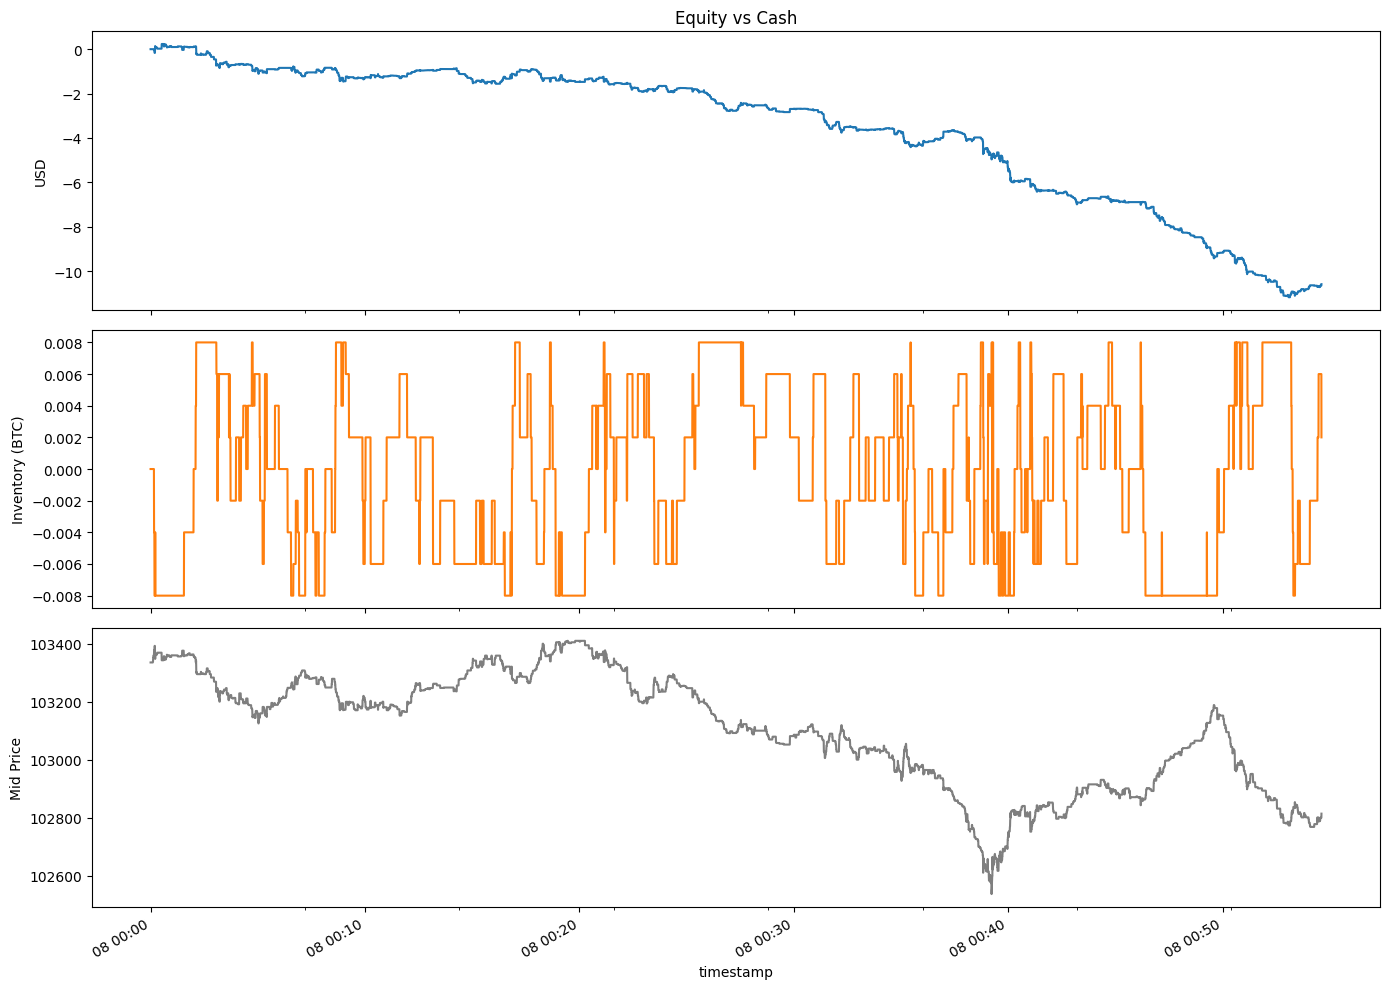

In [23]:
curve = result.frame.set_index("timestamp").iloc[1:, :]
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

curve["equity"].plot(ax=axes[0])
axes[0].set_ylabel("USD")
axes[0].set_title("Equity vs Cash")

curve["position"].plot(ax=axes[1], color="tab:orange")
axes[1].set_ylabel("Inventory (BTC)")

curve["price"].plot(ax=axes[2], color="tab:gray")
axes[2].set_ylabel("Mid Price")

plt.tight_layout()

In [20]:
curve

,price,position,balance,fee,num_trades,trading_volume,trading_value,equity
timestamp,,,,,,,,
2025-11-08 00:00:00.105000+00:00,103335.35,0.000,0.0000,0.000000,0,0.000,0.0000,0.0000
2025-11-08 00:00:00.205000+00:00,103335.35,0.000,0.0000,0.000000,0,0.000,0.0000,0.0000
2025-11-08 00:00:00.305000+00:00,103335.35,0.000,0.0000,0.000000,0,0.000,0.0000,0.0000
2025-11-08 00:00:00.405000+00:00,103335.35,0.000,0.0000,0.000000,0,0.000,0.0000,0.0000
2025-11-08 00:00:00.505000+00:00,103335.35,0.000,0.0000,0.000000,0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...
2025-11-08 00:54:35.518000+00:00,102799.75,0.006,-627.4460,68.059956,631,1.262,130063.1328,-10.6475
2025-11-08 00:54:35.618000+00:00,102799.75,0.006,-627.4460,68.059956,631,1.262,130063.1328,-10.6475
2025-11-08 00:54:35.718000+00:00,102799.75,0.006,-627.4460,68.059956,631,1.262,130063.1328,-10.6475


### Strategy Demo 2

In [2]:
# 1) Convert the OKX CSV (adjust path/limit as needed).
events = demo_convert_okx_csv_for_hftbacktest(
    "btcusdt.csv",
    output_npz=None,      # or "btcusdt.npz" if you want to persist
    limit=2_500_000,
)

# 2) Build the hftbacktest asset + strategy configs.
asset_cfg = AssetBuildConfig(
    feed=events,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    queue_model="risk_adverse",
    exchange_model="partial_fill",
    order_latency_ns=8_000_000,
    response_latency_ns=8_000_000,
)

strat_cfg = BookPressureConfig(
    step_ns=20_000_000,
    max_quote_levels=3,
    quote_spacing_ticks=0.8,
    quote_offset_ticks=0.3,
    min_spread_ticks=0.8,
    maker_order_ttl_ns=200_000_000,
    imbalance_entry=0.62,
    imbalance_exit=0.54,
    momentum_window=30,
    momentum_threshold_ticks=0.6,
    order_size_lots=2.0,
    max_inventory_lots=6.0,
    taker_size_lots=3.0,
    taker_cooldown_ns=150_000_000,
    record_every_n_steps=5,
)

# 3) Run the backtest (increase record_capacity for longer feeds).
result = run_book_pressure_strategy(
    asset_config=asset_cfg,
    strategy_config=strat_cfg,
    record_capacity=250_000,
)
display(result.summary)

{'total_pnl': nan,
 'max_drawdown': 103.71135823898507,
 'num_trades': 14078.0,
 'turnover': 3296495.7023427063,
 'final_inventory': -8.673617379884035e-19}

In [3]:
result.frame

,timestamp,price,position,balance,fee,num_trades,trading_volume,trading_value,equity
0,2262-04-11 23:47:16.854775807+00:00,NaN,0.000000e+00,0.000000,0.000000,0,0.00000,0.000000e+00,NaN
1,2025-11-08 00:00:00.201000+00:00,103335.35,0.000000e+00,0.000000,0.000000,0,0.00000,0.000000e+00,0.000000
2,2025-11-08 00:00:00.877000+00:00,103335.35,0.000000e+00,0.000000,0.000000,0,0.00000,0.000000e+00,0.000000
3,2025-11-08 00:00:01.937000+00:00,103335.35,0.000000e+00,0.000000,0.000000,0,0.00000,0.000000e+00,0.000000
4,2025-11-08 00:00:02.997000+00:00,103335.35,0.000000e+00,0.000000,0.000000,0,0.00000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...
7794,2025-11-08 01:05:30.318000+00:00,103023.55,-6.000000e-03,514.449642,1712.454258,14071,31.97997,3.294641e+06,-103.691658
7795,2025-11-08 01:05:30.578000+00:00,103023.55,-8.673617e-19,-103.691958,1712.886957,14073,31.98597,3.295259e+06,-103.691958
7796,2025-11-08 01:05:30.870000+00:00,103023.55,-8.673617e-19,-103.691958,1712.886957,14073,31.98597,3.295259e+06,-103.691958
7797,2025-11-08 01:05:31.406000+00:00,103026.95,-3.000000e-03,205.369642,1713.226942,14077,31.99497,3.296187e+06,-103.711208


,timestamp,price,position,balance,fee,num_trades,trading_volume,trading_value,equity
7794,2025-11-08 01:05:30.318000+00:00,103023.55,-6.000000e-03,514.449642,1712.454258,14071,31.97997,3.294641e+06,-103.691658
7795,2025-11-08 01:05:30.578000+00:00,103023.55,-8.673617e-19,-103.691958,1712.886957,14073,31.98597,3.295259e+06,-103.691958
7796,2025-11-08 01:05:30.870000+00:00,103023.55,-8.673617e-19,-103.691958,1712.886957,14073,31.98597,3.295259e+06,-103.691958
7797,2025-11-08 01:05:31.406000+00:00,103026.95,-3.000000e-03,205.369642,1713.226942,14077,31.99497,3.296187e+06,-103.711208
7798,2025-11-08 01:05:31.666000+00:00,103026.95,-8.673617e-19,-103.711358,1713.443299,14078,31.99797,3.296496e+06,-103.711358


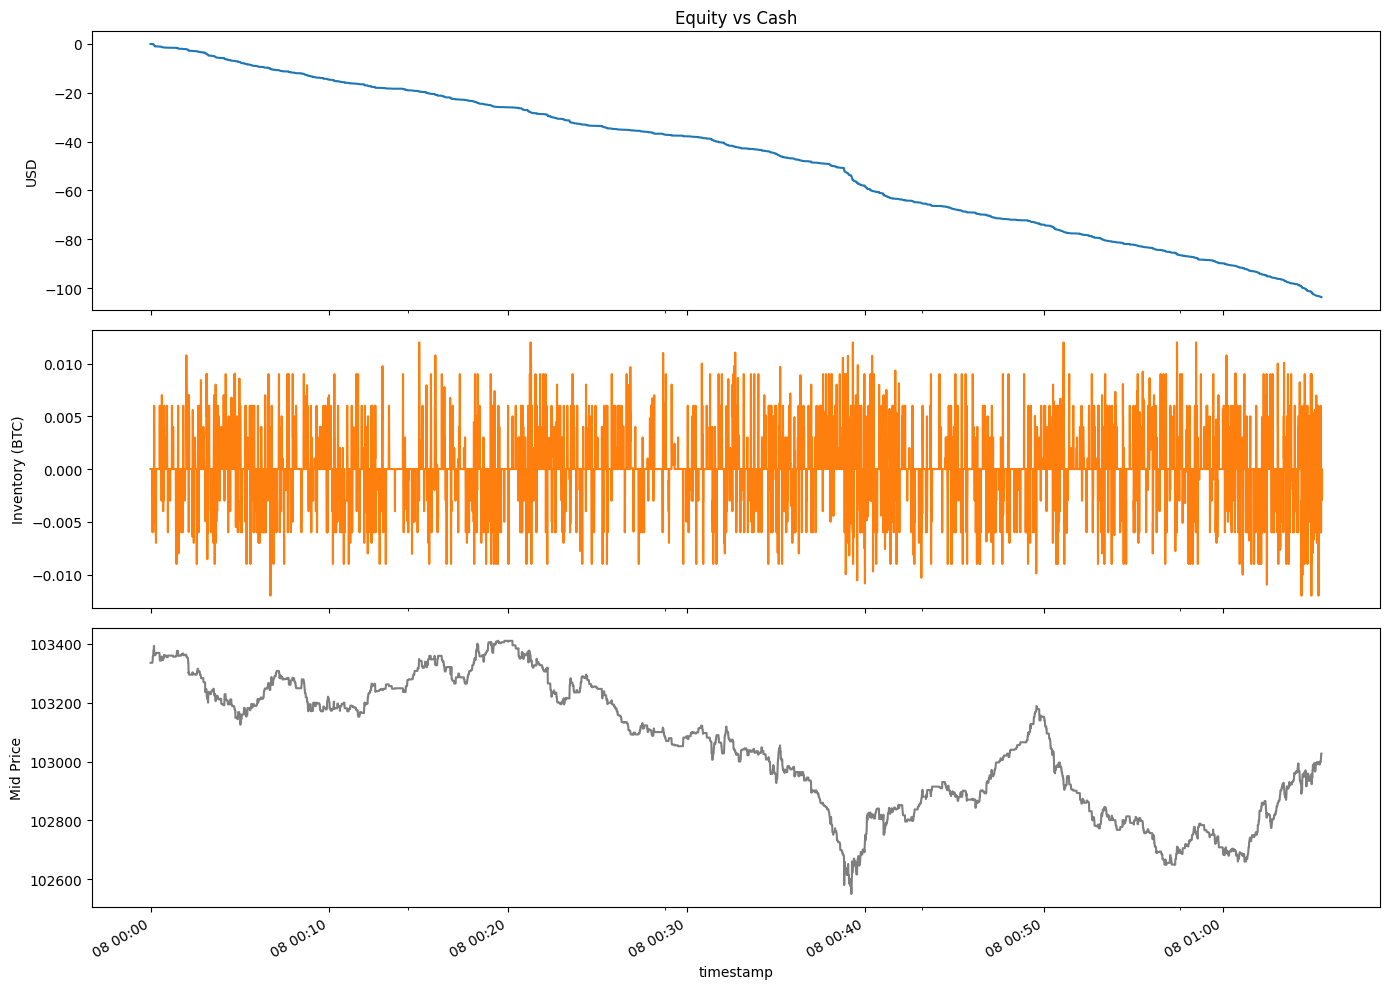

In [4]:
# 4) Visualize PnL & exposures.
curve = result.frame.set_index("timestamp").iloc[1:]
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

curve["equity"].plot(ax=axes[0])
axes[0].set_ylabel("USD"); axes[0].set_title("Equity vs Cash")

curve["position"].plot(ax=axes[1], color="tab:orange")
axes[1].set_ylabel("Inventory (BTC)")

curve["price"].plot(ax=axes[2], color="tab:gray")
axes[2].set_ylabel("Mid Price")

plt.tight_layout()
result.frame.tail()  # inspect recorder samples